In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

E:\anaconda3\envs\jcopdl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from luwiji.random_forest import illustration, demo

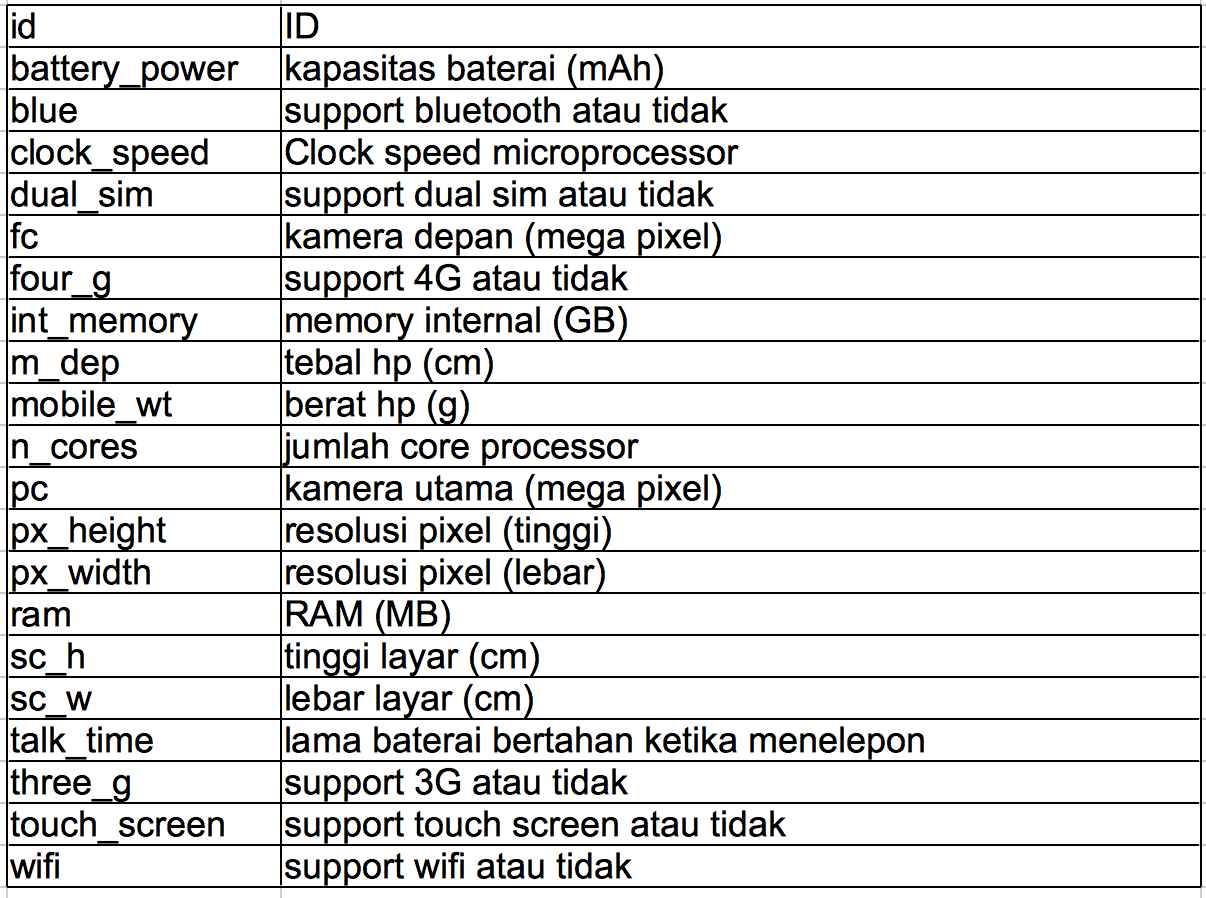

In [3]:
illustration.nomenklatur_mobile

# Import Data

In [4]:
df = pd.read_csv("data/mobile.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


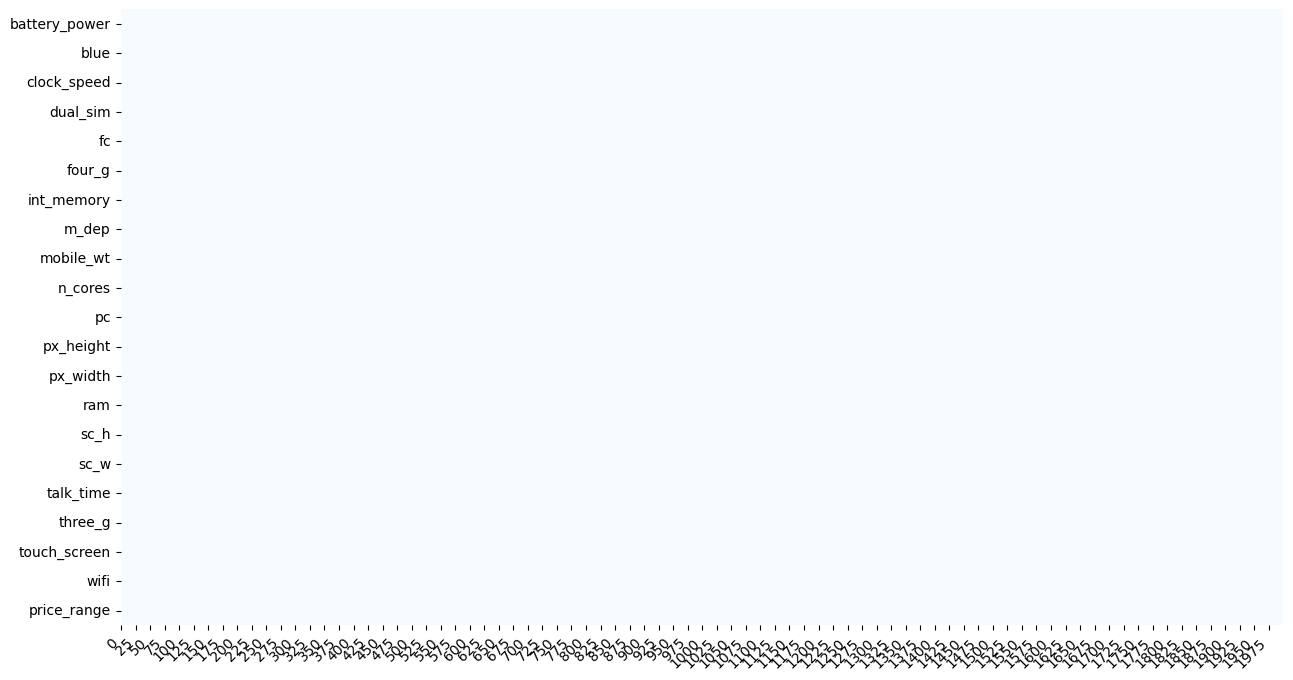

In [5]:
plot_missing_value(df)

# Dataset Splitting

In [6]:
X = df.drop(columns="price_range")
y = df.price_range

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 20), (400, 20), (1600,), (400,))

# Training

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [8]:
X_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
469,1845,1,0.5,1,10,0,61,0.3,96,1,12,292,695,1731,9,5,6,0,0,0
565,1271,1,0.5,0,12,0,32,0.1,113,7,15,1350,1949,445,15,14,14,0,0,1
396,788,0,2.5,1,4,1,57,0.9,91,8,12,42,1161,3969,12,8,6,1,1,1
452,1406,0,0.5,1,2,1,34,0.8,98,3,5,1017,1366,3915,9,8,2,1,0,1
325,920,0,2.1,1,5,0,25,0.4,115,7,14,209,1078,785,10,7,5,0,1,1


In [9]:
df.price_range.value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["battery_power", "clock_speed", "fc", "int_memory", "m_dep", "mobile_wt", 
                             "n_cores", "pc", "px_height", "px_width", "ram", "sc_h", "sc_w", "talk_time"]),
    ('categoric', cat_pipe(encoder='onehot'), ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 100}
1.0 0.8806311528975272 0.9275


# Feature Importance

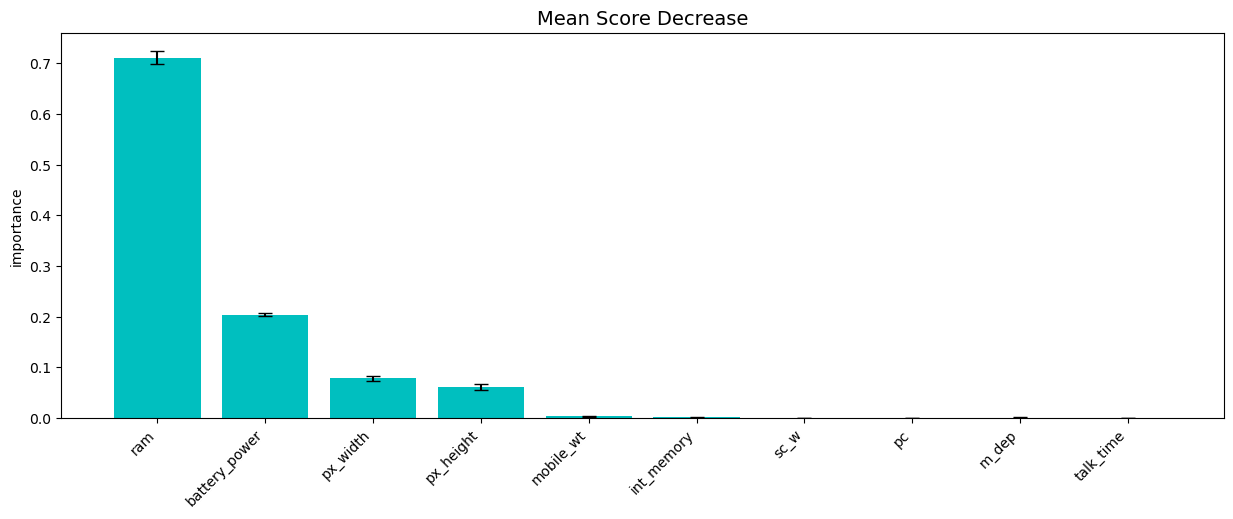

In [11]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

Kenapa mau cut feature?
karena machine punya kelemahan.
tugas machine mencari pola

jika terlalu banyak informasi, pola nya makin tidak ketemu.

* Tapi tidak jamin naik akurasi

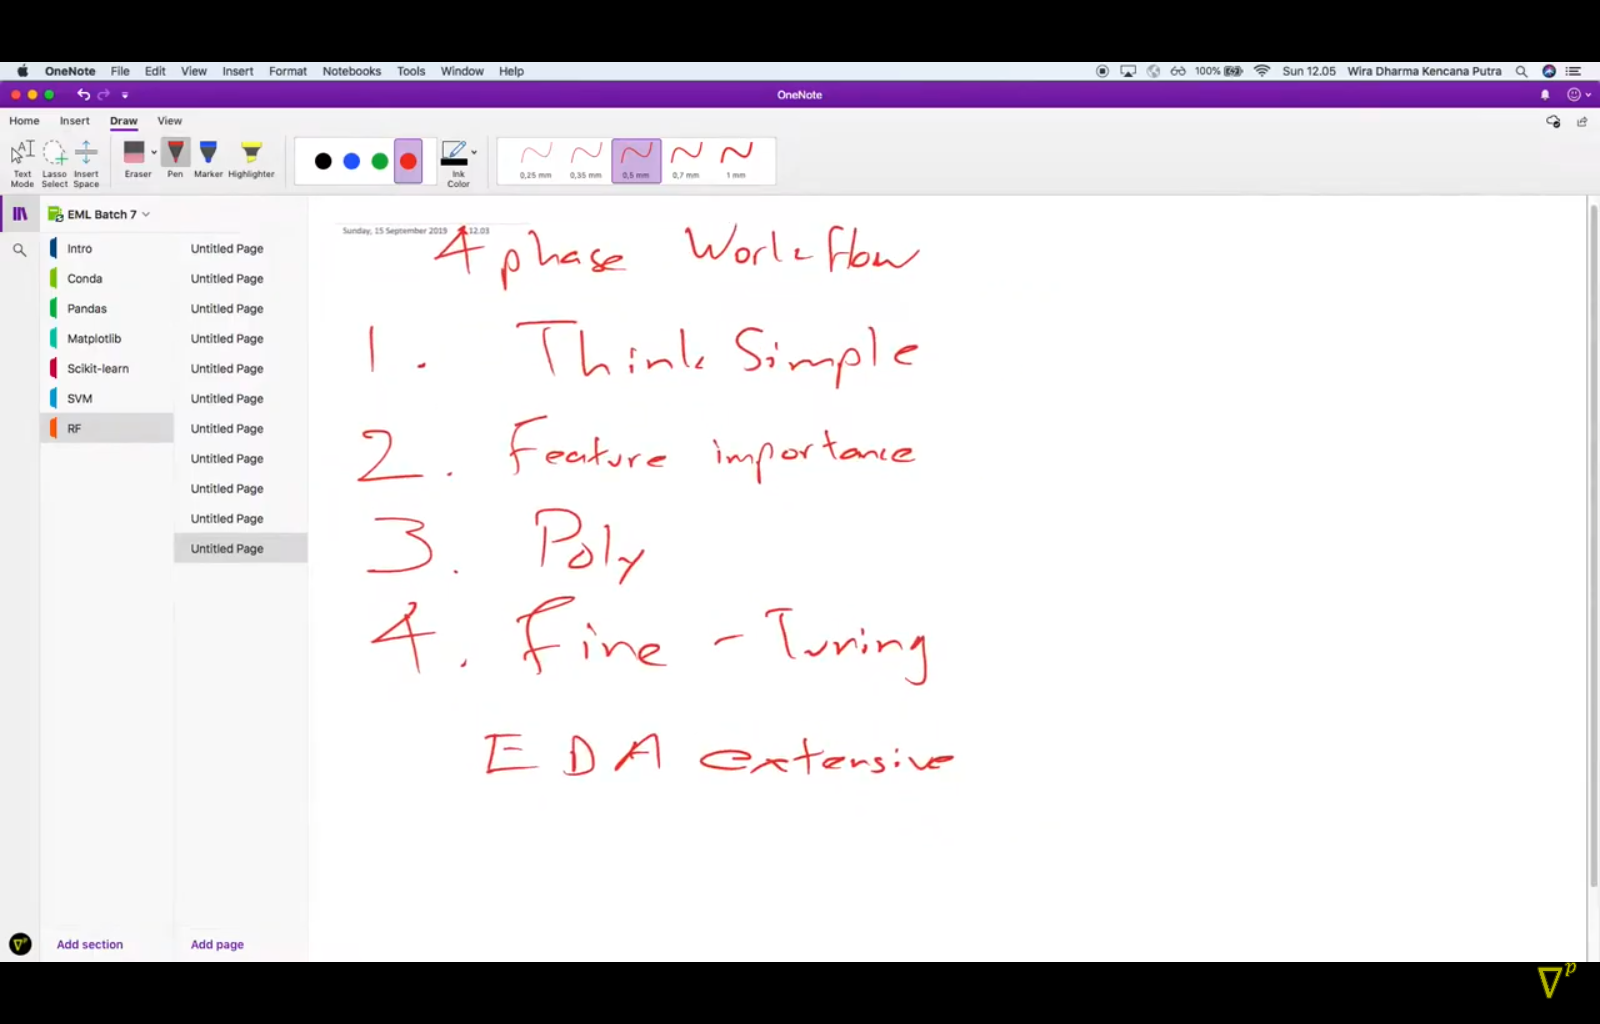

# Phase 2

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["battery_power", "px_height", "px_width", "ram"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.9031264858888864 0.945


# Phase 3: Try Polynomial after feature selection

In [13]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["battery_power", "px_height", "px_width", "ram"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
1.0 0.9262530654692891 0.95


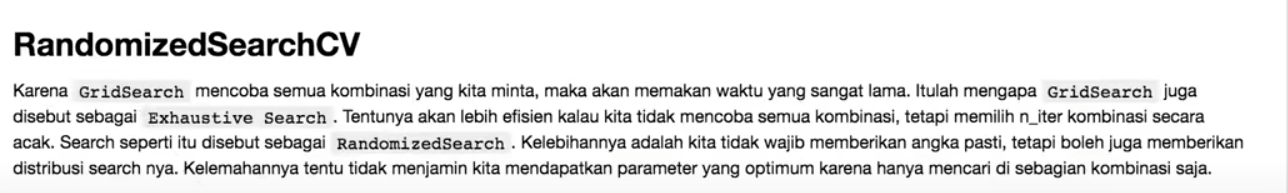

In [14]:
demo.grid_vs_random_search()

interactive(children=(Checkbox(value=False, description='show_score'), Output()), _dom_classes=('widget-intera…

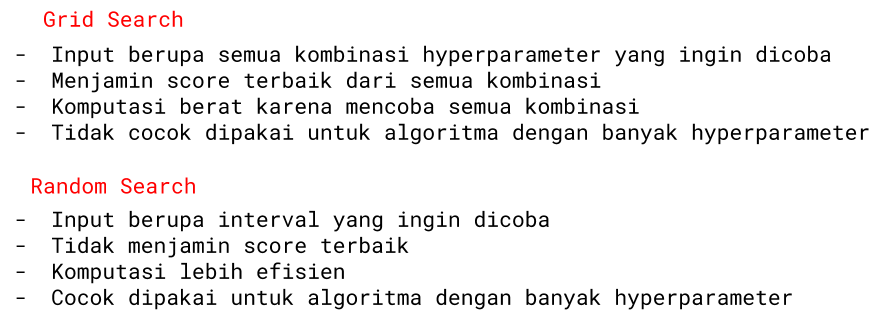

In [15]:
illustration.grid_random_comparison

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [21]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [17]:
rsp.rf_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["battery_power", "px_height", "px_width", "ram"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 71, 'algo__max_features': 0.32218845655474115, 'algo__min_samples_leaf': 7, 'algo__n_estimators': 101, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
0.985625 0.928131580365069 0.95


# Save Model

In [ ]:
save_model(model.best_estimator_, "model.pkl")